In [1]:
using SX, Reachability
using Plots

Open and parse the SX model:

In [4]:
file = "Building_more_decimals.xml"

HDict = readsxmodel(file, raw_dict=true)
H = readsxmodel(file, ST=ConstrainedLinearControlContinuousSystem);

The state variables are `x1` to `x48`, then there is the clock and the input `u1`.

In [5]:
vars = collect(keys(HDict["variables"]))

length(vars), vars[1], vars[48], vars[49], vars[50]

(50, :x1, :x48, :t, :u1)

Build the reachability problem, as an initial value problem with uncertain initial states and inputs:

In [6]:
n = size(H.modes[1].A, 1)-1
A = H.modes[1].A[1:n, 1:n] 
B = eye(n)
X = nothing
U = ConstantInput(H.modes[1].B[1:n, 1] * Hyperrectangle(low=[0.8], high=[1.0]))
S = ConstrainedLinearControlContinuousSystem(A, B, X, U);

In [27]:
initially = " x1 >= 0.0002000 & x1 <= 0.0002500 & x2 >= 0.0002000 & x2 <= 0.0002500 & x3 >= 0.0002000 & x3 <= 0.0002500 & x4 >= 0.0002000 & x4 <= 0.0002500 & x5 >= 0.0002000 & x5 <= 0.0002500 & x6 >= 0.0002000 & x6 <= 0.0002500 & x7 >= 0.0002000 & x7 <= 0.0002500 & x8 >= 0.0002000 & x8 <= 0.0002500 & x9 >= 0.0002000 & x9 <= 0.0002500 & x10 >= 0.0002000 & x10 <= 0.0002500 & x11 >= 0.0000000 & x11 <= 0.0000000 & x12 >= 0.0000000 & x12 <= 0.0000000 & x13 >= 0.0000000 & x13 <= 0.0000000 & x14 >= 0.0000000 & x14 <= 0.0000000 & x15 >= 0.0000000 & x15 <= 0.0000000 & x16 >= 0.0000000 & x16 <= 0.0000000 & x17 >= 0.0000000 & x17 <= 0.0000000 & x18 >= 0.0000000 & x18 <= 0.0000000 & x19 >= 0.0000000 & x19 <= 0.0000000 & x20 >= 0.0000000 & x20 <= 0.0000000 & x21 >= 0.0000000 & x21 <= 0.0000000 & x22 >= 0.0000000 & x22 <= 0.0000000 & x23 >= 0.0000000 & x23 <= 0.0000000 & x24 >= 0.0000000 & x24 <= 0.0000000 & x25 >= -0.0001000 & x25 <= 0.0001000 & x26 >= 0.0000000 & x26 <= 0.0000000 & x27 >= 0.0000000 & x27 <= 0.0000000 & x28 >= 0.0000000 & x28 <= 0.0000000 & x29 >= 0.0000000 & x29 <= 0.0000000 & x30 >= 0.0000000 & x30 <= 0.0000000 & x31 >= 0.0000000 & x31 <= 0.0000000 & x32 >= 0.0000000 & x32 <= 0.0000000 & x33 >= 0.0000000 & x33 <= 0.0000000 & x34 >= 0.0000000 & x34 <= 0.0000000 & x35 >= 0.0000000 & x35 <= 0.0000000 & x36 >= 0.0000000 & x36 <= 0.0000000 & x37 >= 0.0000000 & x37 <= 0.0000000 & x38 >= 0.0000000 & x38 <= 0.0000000 & x39 >= 0.0000000 & x39 <= 0.0000000 & x40 >= 0.0000000 & x40 <= 0.0000000 & x41 >= 0.0000000 & x41 <= 0.0000000 & x42 >= 0.0000000 & x42 <= 0.0000000 & x43 >= 0.0000000 & x43 <= 0.0000000 & x44 >= 0.0000000 & x44 <= 0.0000000 & x45 >= 0.0000000 & x45 <= 0.0000000 & x46 >= 0.0000000 & x46 <= 0.0000000 & x47 >= 0.0000000 & x47 <= 0.0000000 & x48 >= 0.0000000 & x48 <= 0.0000000 & t==0";
f = i -> SX.parse_sxmath(initially)[i].args[3]
X0 = Hyperrectangle(low=[f(i) for i in 1:2:96], high=[f(i) for i in 2:2:96])
problem = InitialValueProblem(S, X0)
initial_δ = 0.005
time_horizon = 20.0;

We see that for the discretization step $\delta = 0.005$ given in the config file, the decomposition algorithm is not precise enough and violated the property:

[info] Time discretization...
[info] elapsed time: 0.007712792 seconds
[info] Reachable States Computation...
[info] - Decomposing X0
[info] elapsed time: 0.002593151 seconds
[info] - Computing successors
[info] elapsed time: 0.618744915 seconds
[info] - Total
[info] elapsed time: 0.623496418 seconds
[info] Projection...
[info] elapsed time: 0.04249765 seconds


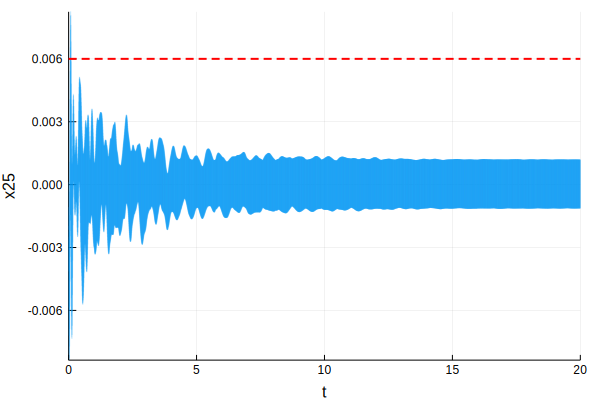

In [29]:
sol = solve(problem, :T=>time_horizon, :δ=>initial_δ, :vars=>[25], :verbosity=>1)
plot(sol, alpha=0.2)
plot!(x->x, x->0.006, 0.0, time_horizon, line=2, color="red", linestyle=:dash, legend=nothing)

We can use the `:check` mode to find the maximum delta such that the property is satisfied.

In [30]:
precision = 1e-4
algorithm(N, δ) = solve(S, :mode => "check", :vars => [25],
                           :δ => δ,
                           :T => time_horizon,
                           :property => LinearConstraintProperty(sparsevec([25], [1.0], 49), 0.006)).satisfied

Properties.tune_δ(algorithm, time_horizon, precision, initial_δ)

INFO: Iteration 1
INFO: δ: 0.005


LoadError: [91mtype ConstrainedLinearControlContinuousSystem has no field s[39m

In [ ]:
sol = solve(problem, :T=>time_horizon, :δ=>δ_max, :vars=>[25], :verbosity=>1);

Finally let's visualize the reachability computation for this value of $\delta$:

In [ ]:
sol = solve(problem, :T=>time_horizon, :δ=>δ_max, :vars=>[25], :verbosity=>1)
plot(sol, alpha=0.2)
plot!(x->x, x->0.006, -0.8, 1.3, line=2, color="red", linestyle=:dash)